<a href="https://colab.research.google.com/github/perejfm/thesis-code/blob/main/Scalation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def SourceCVE(list, key):
  source=[]
  for vuln in list.get(key):
    aux = {}
    if key=="Grype.txt":
      aux["CVE"]=vuln.get("vulnerability").get("id");
      aux["dependency"]=vuln.get("artifact").get("name")
      aux["path"]=vuln.get("artifact").get("locations")[0].get("path")

    elif key=="Scantist.json":
      aux["CVE"]=vuln.get("Vulnerability ID")
      aux["dependency"]=vuln.get("Library")
      aux["path"]=vuln.get("File Path")

    elif key=="Snyk.txt":
      aux["CVE"]=vuln.get("identifiers").get("CVE")[0];
      aux["dependency"]=vuln.get("moduleName")
      aux["path"]=vuln.get("path")

    elif key=="Trivy.txt":
      aux["CVE"]=vuln.get("VulnerabilityID")
      aux["dependency"]=vuln.get("PkgID")
      aux["path"]=vuln.get("Path")
    source.append(aux)
  return source;

These methods are the ones used for formatting the dirty documents from the different tools

In [ ]:
from copy import error
from typing import List

def formatting(repo,tool):
  if tool=="Grype.txt":
    return formatGrype(repo)
  elif tool=="Scantist.json":
    return formatScantist(repo)
  elif tool=="Snyk.txt":
    return formatSnyk(repo)
  elif tool=="Trivy.txt":
    return formatTrivy(repo)

def formatGrype(repo):
  GrypeRepo=json.loads(repo)
  vulnArray=[]
  for vuln in GrypeRepo["matches"]:
    vulnArray.append(vuln)
  return vulnArray

def formatScantist(repo):
  content =json.loads(repo)
  vuln=content["items"]
  return vuln;

def formatSnyk(repo):
  content=json.loads(repo)
  allvuln=[]
  if("error" not in content):
    for target in content:
      if not isinstance(target, str):
        #breakpoint()
        vulnList=target.get('vulnerabilities')
        path=target.get('displayTargetFile')
        for vuln in vulnList:
          vuln.pop('semver')
          vuln['path']=path
          allvuln.append(vuln)
      else:
        if target =='vulnerabilities':
           vulnList=content.get('vulnerabilities')
           #breakpoint()
           for vuln in vulnList:
              vuln.pop('semver')
              #vuln['path']=path
              allvuln.append(vuln)
           print("1")
  else:
    global repoWithError
    repoWithError.append(os.path.basename(content['path']))
  return allvuln;

def formatTrivy(repo):
  index=repo.find("{")
  repo= repo[index:]
  TrivyRepo=json.loads(repo)
  results=TrivyRepo.get("Results")
  vulnArray =[]
  if results is not None:
    for target in results:
      path=target.get("Target")
      vulnTarget=target.get("Vulnerabilities"); #this is an copy of each of the array that we made and add the path manually
      for vuln in vulnTarget:
          vuln["Path"]=path;
      vulnArray.extend(vulnTarget)
  return vulnArray;



The following methods are the ones use to create the comparation matrix and the Statistical analysis.

In [ ]:
#Creates an nxn Matrix where each element is
#an array of CVES that tool1 and tool2 have in common.
def comparasion_matrix(list):
  AllCves=[]
  n=len(list)
  aux_matrix=[]
  final_matrix=[]
  for tool in list:
   AllCves.append(CVE(list,tool))
  for tool1 in AllCves:
    for tool2 in AllCves:
      shared_cves=comparing_cves(tool1,tool2)
      aux_matrix.append(shared_cves)
  for i in range(0,n): #rearange in nxn format
    row = aux_matrix[i*n:i*n+n]
    final_matrix.append(row)
  return final_matrix;


#Return the different CVES deppending of the tool which is specified in the parameters
def CVE(list, key):
  cve=[]
  for vuln in list.get(key):
    if key=="Grype.txt":
      cve.append(vuln.get("vulnerability").get("id"))
    elif key=="Scantist.json":
      cve.append(vuln.get("Vulnerability ID"))
    elif key=="Snyk.txt":
      if len(vuln.get("identifiers").get("CVE"))==0:
        cve.append("unidentified")
      else:
        cve.append(vuln.get("identifiers").get("CVE")[0])
    elif key=="Trivy.txt":
      cve.append(vuln.get("VulnerabilityID"))
  return cve;

#Return an array with the CVE and CVSS of each vulnerability deppending of the tool which is specified in the parameters
def CVEandCVSS(list, key):
  cvss=[]
  for vuln in list.get(key):
    aux = {}
    if key=="Grype.txt":
        aux["CVE"]=vuln.get("vulnerability").get("id");
        aux["CVSS"]=vuln.get("vulnerability").get("cvss")[0].get("metrics").get("baseScore");
    elif key=="Scantist.json":
      aux["CVE"]=vuln.get("Vulnerability ID");
      aux["CVSS"]=vuln.get("Score");
    elif key=="Snyk.txt":
      if len(vuln.get("identifiers").get("CVE"))==0:
        aux["CVE"]="unidentified"
      else:
        aux["CVE"]=vuln.get("identifiers").get("CVE")[0]
      aux["CVSS"]=vuln.get("cvssScore");
    elif key=="Trivy.txt":
      aux["CVE"]=vuln.get("VulnerabilityID")
      cvss_value = vuln.get("CVSS")
      if cvss_value is not None:  #Trivy sometimes has GHSA vuln that are not graded so we need to check it first
        nvd_value=cvss_value.get("nvd")
        ghsa_value=cvss_value.get("ghsa")
        if  nvd_value is not None:
          aux["CVSS"] = nvd_value.get("V3Score")
        elif ghsa_value is not None:
          aux["CVSS"]= ghsa_value.get("V3Score")
      else:
          aux["CVSS"] =None
    cvss.append(aux)
  return cvss;

#it dumps all the CVSS+CVE in an array
def AllCVSS(list):
  AllCVE_CVSS=[]
  for tool in list:
    AllCVE_CVSS.extend(CVEandCVSS(list,tool))
  return AllCVE_CVSS;

#makes the average of all the CVSS without taking into account the ones that do not have CVSS
#I can not use the one from the library np since sometime we have None values and we have to acess the values
def average(list):
  sum=0;
  n=0;
  for cve in list:
    if cve.get("CVSS") is not None:
      sum+=cve.get("CVSS")
      n+=1
  if n>0:
    return sum/n
  else:
    return 0


def deviation(list):
    avg=average(list)
    dev=[]
    for cve in list:
      if cve.get("CVSS") is not None:
        dev.append(pow(cve.get("CVSS")-avg,2))
    avgDev=np.mean(dev)
    return np.sqrt(avgDev)

def median(list):
  aux=[]
  for cve in list:
    if cve.get("CVSS") is not None:
      aux.append(cve.get("CVSS"))
  return np.median(aux)


#eliminate duplicates from a CVE+CVSS list
def noduplicates_CVSS(list):
  uniqueVuln = set()
  FinalArray=[]
  for vuln in list:
    if vuln.get("CVE") not in uniqueVuln:
      uniqueVuln.add(vuln.get("CVE"))
      FinalArray.append(vuln)
  return FinalArray;



#compares 2 list of CVES returning a list of the ones that matches both lists
def comparing_cves(cves1,cves2):
  shared_cves=[]
  for cve in cves1:
    if cve in cves2:
      shared_cves.append(cve)
  return shared_cves

def correlation():
  return 0

The following code extracts the information from the documents, formats it and compute some stats analysis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


dirty_path = '/content/drive/MyDrive/PereThesis/Scaling/Dirty Results'
stats_result_path= '/content/drive/MyDrive/PereThesis/Scaling/Results/StatsResults.txt'
file_contents = {}

repoWithError=[];

with open(stats_result_path, 'w') as fileSR: #file Results
  for repo_class in sorted(os.listdir(dirty_path)):
    repo_class_path=os.path.join(dirty_path, repo_class)
    for repo_folder in sorted(os.listdir(repo_class_path)):
      file_contents[repo_folder]={}
      file_contents[repo_folder]["repoClass"]=repo_class;
      file_contents[repo_folder]["tools"]={};
      fileSR.write(repo_folder+"\n")
      repo_path=os.path.join(repo_class_path, repo_folder)
      for tool in sorted(os.listdir(repo_path)):
        tool_path = os.path.join(repo_path, tool)
        fileSR.write("\t"+tool+"\n")
        with open(tool_path, 'r') as file:
          content = file.read()
        formatted = formatting(content,tool)
        file_contents[repo_folder]["tools"][tool]=formatted
        """
        cvss=CVEandCVSS(file_contents[repo_folder]["tools"],tool)
        num=len(cvss)
        fileSR.write("\t\t" +"number of CVSS: "+str(num)+"\n")
        if num>0:
          clnCvss=noduplicates_CVSS(cvss)
          clnNum=len(clnCvss)
          avg=average(cvss)
          clnAvg=average(clnCvss)
          dev=deviation(cvss)
          clnDev=deviation(clnCvss)
          med=median(cvss)
          clnMed=median(clnCvss)
          fileSR.write("\t\t" +"number of CVSS (without duplicates): "+str(clnNum)+"\n")
          fileSR.write("\t\t" +"CVSS Average: "+str(avg)+"\n")
          fileSR.write("\t\t" +"CVSS Average (without duplicates): "+str(clnAvg)+"\n")
          fileSR.write("\t\t" +"CVSS Deviation: "+str(dev)+"\n")
          fileSR.write("\t\t" +"CVSS Deviation (without duplicates): "+str(clnDev)+"\n")
          fileSR.write("\t\t" +"CVSS Median: "+str(med)+"\n")
          fileSR.write("\t\t" +"CVSS Median (without duplicates): "+str(clnMed)+"\n")
      fileSR.write("\tAll \n")
      all=AllCVSS(file_contents[repo_folder])
      num=len(all)
      fileSR.write("\t\t" +"Total number of CVSS: "+str(num)+"\n")
      if num>0:
        clnall=noduplicates_CVSS(all)
        clnNum=len(clnall)
        avg=average(all)
        clnAvg=average(clnall)
        dev=deviation(all)
        clnDev=deviation(clnall)
        med=median(all)
        clnMed=median(clnall)
        fileSR.write("\t\t" +"total number of CVSS (without duplicates): "+str(clnNum)+"\n")
        fileSR.write("\t\t" +"CVSS Average: "+str(avg)+"\n")
        fileSR.write("\t\t" +"CVSS Average (without duplicates): "+str(clnAvg)+"\n")
        fileSR.write("\t\t" +"CVSS Deviation: "+str(dev)+"\n")
        fileSR.write("\t\t" +"CVSS Deviation (without duplicates): "+str(clnDev)+"\n")
        fileSR.write("\t\t" +"CVSS Median: "+str(med)+"\n")
        fileSR.write("\t\t" +"CVSS Median (without duplicates): "+str(clnMed)+"\n")
"""



1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


The following code is used to represent the number of vulnerabilities founds by each tool and in average. It also shows the the mean of the CVSS found by all the tools.



In [ ]:
comparing_matrix_path= '/content/drive/MyDrive/PereThesis/Scaling/Results/ComparingMatrix.txt'
sharedCVEs_path= '/content/drive/MyDrive/PereThesis/Scaling/Results/SharedCVEs.txt'

with open(comparing_matrix_path, 'w') as fileM:
  for repo in file_contents:
    fileM.write(repo+"\n")
    fileM.write("\tComparison Matrix:")
    Com_matrix=comparasion_matrix(file_contents[repo])
    n=len(file_contents[repo])
    for i in range(0,n):
      fileM.write("\n \t")
      for j in range(0,n):
        fileM.write(str(len(Com_matrix[i][j]))+" ")
    fileM.write("\n")
    fileM.write("\tComparison Matrix (without duplicates):")

    for i in range(0,n):
      fileM.write("\n \t")
      for j in range(0,n):
        fileM.write(str(len(list(set(Com_matrix[i][j]))))+" ")
    fileM.write("\n")


with open(sharedCVEs_path, 'w') as fileS:
  for repo in file_contents:
    fileS.write("\n"+repo+"\n")
    com_matrix=comparasion_matrix(file_contents[repo])
    tools=[]
    for tool in file_contents[repo]:
      tools.append(tool)
    n=len(tools)
    for i in range(0,n):
      for j in range(0,n):
        ncve=len(list(set(com_matrix[i][j])))
        if ncve>0:
          fileS.write("\n\t"+str(ncve)+" shared CVE of "+str(tools[i])+" and "+str(tools[j])+":\n")
          for cve in list(set(com_matrix[i][j])):
            fileS.write("\t"+cve+"\n")




11.333333333333334
9.666666666666666
4.222222222222222
17.444444444444443
2.2325581395348837
3.511627906976744
0.3488372093023256
5.046511627906977
6.0
5.0
2.0
8.0
0.0
0.0
0.0
0.0
6.079411764705881
6.77471264367816
5.957894736842106
6.6138157894736835
6.929166666666667
6.903311258278145
7.053333333333333
7.12073732718894
6.05
7.0
5.3
7.0
7.5
7.5
7.4
7.5


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

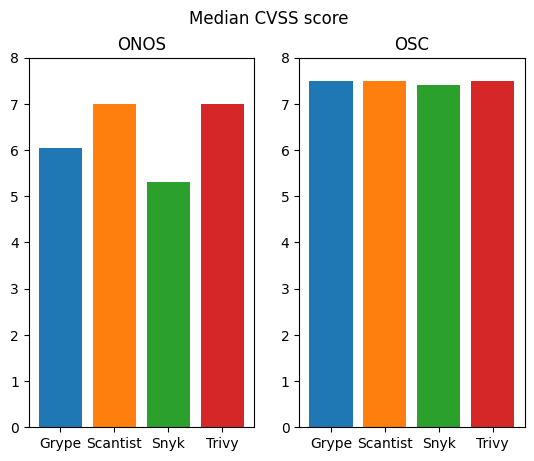

In [ ]:
numVuln={
    'ONOS':{
      'Grype.txt':{},
      'Scantist.json':{},
      'Snyk.txt':{},
      'Trivy.txt':{}
      },
    'OSC':{
      'Grype.txt':{},
      'Scantist.json':{},
      'Snyk.txt':{},
      'Trivy.txt':{}
    }
}
for repoClass in numVuln:
  for tool in numVuln[repoClass]:
    numVuln[repoClass][tool]['num'] =[]
    numVuln[repoClass][tool]['repo']=[]
    numVuln[repoClass][tool]['CVSS']=[]


for repo in file_contents:
  for tool in file_contents[repo]['tools']:
    repoClass=file_contents[repo]['repoClass']
    cvss=CVEandCVSS(file_contents[repo]['tools'],tool)
    clnCvss=noduplicates_CVSS(cvss)
    num=len(clnCvss)
    numVuln[repoClass][tool]['num'].append(num)
    numVuln[repoClass][tool]['repo'].append(repo)
    for icvss in clnCvss:
      ext=icvss['CVSS']
      numVuln[repoClass][tool]['CVSS'].append(ext)
plt.clf()
for repoClass in numVuln:
    plt.clf()  # Clear the previous plot
    fig, ax = plt.subplots()
    repo = numVuln[repoClass]['Trivy.txt']['repo']
    Snyk = numVuln[repoClass]['Snyk.txt']['num']
    Scantist = numVuln[repoClass]['Scantist.json']['num']
    Trivy = numVuln[repoClass]['Trivy.txt']['num']
    Grype = numVuln[repoClass]['Grype.txt']['num']
    n=len(repo)
    r = np.arange(n)
    width = 0.15

    """should_continue = any(val % 4 == 0 for val in r)
    if should_continue:
        continue"""

    plt.bar(r - width * 3, Snyk, width=width, color='#7f58af', label='Snyk')
    plt.bar(r - width * 2, Scantist, width=width, color='#64c5eb', label='Scantist')
    plt.bar(r - width, Trivy, width=width, color='#e84d8a', label='Trivy')
    plt.bar(r, Grype, width=width, color='#feb326', label='Grype')

    plt.title("Number of vulnerabilities in " + repoClass)
    plt.xlabel("Repositories")
    plt.xticks(r - width, repo)
    plt.ylabel("Number of Vulnerabilities")
    plt.xticks(fontsize=7, rotation=90)
    ax.legend(loc='upper right', prop={'size': 6})
    plt.tight_layout()
    save_path = '/content/drive/MyDrive/PereThesis/Scaling/Results/figures/' + repoClass + '/total.pdf'
    plt.savefig(save_path)

plt.clf()
fig, axs = plt.subplots(1, 2)
i=0;
for repoClass in numVuln:
  ax=axs[i]
  i+=1;
  for tool in numVuln[repoClass]:
    avg=np.mean(numVuln[repoClass][tool]['num']);
    print(avg)
    ax.bar(os.path.splitext(tool)[0],avg)
    ax.set_title(repoClass)
    ax.set_ylim((0, 18))
fig.suptitle('Average number of vulnerabilities found')
fig.savefig('/content/drive/MyDrive/PereThesis/Scaling/Results/figures/Avg.pdf')

plt.clf()
fig, axs = plt.subplots(1, 2)
i=0;
for repoClass in numVuln:
  ax=axs[i]
  i+=1;
  for tool in numVuln[repoClass]:
    median=np.median(numVuln[repoClass][tool]['num']);
    print(median)
    ax.bar(os.path.splitext(tool)[0],median)
    ax.set_title(repoClass)
    ax.set_ylim((0, 9))
fig.suptitle("Median of the number of vulnerabilities found")
fig.savefig('/content/drive/MyDrive/PereThesis/Scaling/Results/figures/MedianVulnFound.pdf')


plt.clf()
fig, axs = plt.subplots(1, 2)
i=0;
for repoClass in numVuln:
  ax=axs[i]
  i+=1;
  for tool in numVuln[repoClass]:
    filteredCvss= [value for value in numVuln[repoClass][tool]['CVSS'] if value is not None]
    avg=np.mean(filteredCvss);
    print(avg)
    ax.bar(os.path.splitext(tool)[0],avg)
    ax.set_title(repoClass)
    ax.set_ylim((0, 7.5))
fig.suptitle("Average CVSS score")
fig.savefig('/content/drive/MyDrive/PereThesis/Scaling/Results/figures/AverageCVSSFoundIn.pdf')

plt.clf()
fig, axs = plt.subplots(1, 2)
i=0;
for repoClass in numVuln:
  ax=axs[i]
  i+=1;
  for tool in numVuln[repoClass]:
    filteredCvss= [value for value in numVuln[repoClass][tool]['CVSS'] if value is not None]
    median=np.median(filteredCvss);
    print(median)
    ax.bar(os.path.splitext(tool)[0],median)
    ax.set_title(repoClass)
    ax.set_ylim((0, 8))
fig.suptitle("Median CVSS score")
fig.savefig('/content/drive/MyDrive/PereThesis/Scaling/Results/figures/MedianCVSSFoundIn.pdf')


In [ ]:
numVuln

{'ONOS': {'Grype.txt': {'num': [1, 2, 6, 6, 36, 0, 6, 9, 36],
   'repo': ['onos-a1t',
    'onos-cli',
    'onos-config',
    'onos-e2t',
    'onos-kpimon',
    'onos-lib-go',
    'onos-operator',
    'onos-topo',
    'onos-uenib'],
   'CVSS': [9.6,
    7.5,
    7.5,
    7.5,
    5.5,
    6.8,
    6.8,
    5.3,
    7.5,
    7.5,
    5.5,
    6.8,
    6.8,
    5.3,
    7.5,
    5,
    4.6,
    5,
    5,
    9.3,
    5,
    2.7,
    4.3,
    5,
    7.5,
    5.5,
    5.7,
    6.8,
    5.3,
    5.5,
    3,
    5.3,
    7.5,
    7.5,
    5.3,
    6.8,
    3,
    6.5,
    7.5,
    7.5,
    5.9,
    6.1,
    5.3,
    7.5,
    2.5,
    8,
    4.3,
    3,
    6,
    7,
    7.5,
    7.5,
    7.5,
    7.5,
    5.3,
    9.1,
    7.5,
    7.5,
    5.5,
    6.8,
    7.5,
    7.5,
    6.8,
    5.3,
    7.5,
    7.5,
    5,
    4.6,
    5,
    5,
    9.3,
    5,
    2.7,
    4.3,
    5,
    7.5,
    5.5,
    5.7,
    6.8,
    5.3,
    5.5,
    3,
    5.3,
    7.5,
    7.5,
    5.3,
    6.8,
    3,
    

Representar correlation Matrix

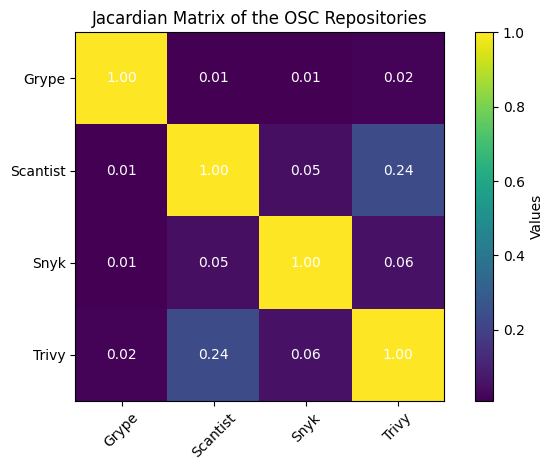

In [ ]:
jacardianMatrix={
    'ONOS':[],
    'OSC':[]
    }

for classRepo in jacardianMatrix:
  for i in range (0,4):
    jacardianMatrix[classRepo].append([])
    for j in range(0,4):
      jacardianMatrix[classRepo][i].append([])

trace=0
toolWithSc=["Grype.txt","Scantist.json","Snyk.txt","Trivy.txt"]
tools=["Grype","Scantist","Snyk","Trivy"]
toolWithoutSc=["Grype.txt","Snyk.txt","Trivy.txt"]
for repo in file_contents:
  Com_matrix=comparasion_matrix(file_contents[repo]['tools'])
  n=len(file_contents[repo]['tools'])
  for i in range(0,n):
    for j in range(0,n):
      tool =toolWithSc if n>3 else toolWithoutSc
      common=len(list(set(Com_matrix[i][j])))
      iFind= len(list(set(CVE(file_contents[repo]['tools'],tool[i]))))
      jFind= len(list(set(CVE(file_contents[repo]['tools'],tool[j]))))
      if jFind+iFind>0:
        JaccardIndex = common /(iFind+jFind-common);
        jacardianMatrix[file_contents[repo]['repoClass']][i][j].append(JaccardIndex)
n

jacardianMatrixAvg={
    'ONOS':[],
    'OSC':[]
    }

for classRepo in jacardianMatrix:
  n=4
  for i in range (0,n):
    jacardianMatrixAvg[classRepo].append([])
    for j in range(0,n):
      jacardianMatrixAvg[classRepo][i].append([])
      jacardianMatrixAvg[classRepo][i][j]=np.mean(jacardianMatrix[classRepo][i][j])


for classRepo in jacardianMatrix:
  plt.clf()
  plt.imshow(jacardianMatrixAvg[classRepo])
  cbar = plt.colorbar()
  cbar.set_label('Values')

  jacardianMatrixAvg[classRepo]=np.array(jacardianMatrixAvg[classRepo])
  for i in range(jacardianMatrixAvg[classRepo].shape[0]):
      for j in range(jacardianMatrixAvg[classRepo].shape[1]):
          plt.text(j, i, f'{jacardianMatrixAvg[classRepo][i, j]:.2f}', ha='center', va='center', color='white')
  plt.title('Jacardian Matrix of the '+classRepo+' Repositories')
  plt.xticks(range(len(tools)), tools, rotation=45)
  plt.yticks(range(len(tools)), tools)
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/PereThesis/Scaling/Results/figures/'+classRepo+'/JaccardianMatrix.pdf')




dependencies and path

In [ ]:
"""dependencies_path= '/content/drive/MyDrive/PereThesis/Scaling/Results/Dependencies.txt'
with open(dependencies_path, 'w') as fileD: #file Dependencies
  for repo in file_contents:
    fileD.write(repo+"\n")
    for tool in file_contents[repo]['tools']:
      fileD.write("\t"+tool+"\n")
      sourceList=SourceCVE(file_contents[repo]['tools'],tool)
      for source in sourceList:
        fileD.write("\t"+str(source)+"\n")"""


'dependencies_path= \'/content/drive/MyDrive/PereThesis/Scaling/Results/Dependencies.txt\'\nwith open(dependencies_path, \'w\') as fileD: #file Dependencies\n  for repo in file_contents:\n    fileD.write(repo+"\n")\n    for tool in file_contents[repo][\'tools\']:\n      fileD.write("\t"+tool+"\n")\n      sourceList=SourceCVE(file_contents[repo][\'tools\'],tool)\n      for source in sourceList:\n        fileD.write("\t"+str(source)+"\n")'